In [1]:
#Import necessary packages
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twitter_new.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [5]:
df['target'].unique()  #Check unique Target Values

array([0, 4], dtype=int64)

In [6]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

### Data Visualization of Target Variables

<AxesSubplot:xlabel='target', ylabel='count'>

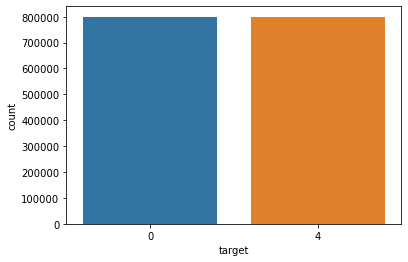

In [7]:
sns.countplot(x='target', data=df) #Data Visualization of Target Variables

### Data Preprocessing 

In [8]:
df = df[['text','target']]     #Selecting the text and Target column for further analysis

In [9]:
df['target'] = df['target'].replace(4,1) #Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

In [10]:
df

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


In [11]:
#Data cleaning #stopword removal and special characters
import re
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    # Remove link,user,special characters
    text = re.sub(TEXT_CLEANING_RE," ",str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)

df['text'] = df['text'].apply(lambda x: preprocess(x))
df['text'].head()

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2    dived many times ball managed save 50 rest go ...
3                     whole body feels itchy like fire
4                                     behaving mad see
Name: text, dtype: object

In [12]:
df['text'] = df['text'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))

In [13]:
#removing &quot and &amp after identifying them from wordcloud 
def cleaning_new(data):
    return re.sub('((amp[^s]+)|(quot[^s]+))',' ',data)
df['text'] = df['text'].apply(lambda x: cleaning_new(x))
df['text'].head(10)

0         awww bummer shoulda got david carr third day
1    upset update facebook texting might cry result...
2       dived many times ball managed save rest bounds
3                     whole body feels itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rains bit bit lol fine t...
8                                                 nope
9                                            que muera
Name: text, dtype: object

In [14]:
# Begin Lemmatization 

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()

# Finds the part of speech tag
# Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df['text'] = df['text'].apply(lambda x: lemmatize_sentence(x))
df['text']

0               awww bummer shoulda get david carr third day
1          upset update facebook texting might cry result...
2                 dive many time ball manage save rest bound
3                            whole body feel itchy like fire
4                                             behave mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996              thewdb com cool hear old walt interview
1599997                       ready mojo makeover ask detail
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

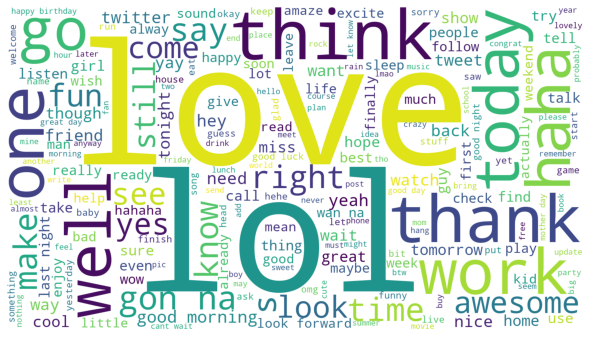

In [15]:
from wordcloud import WordCloud
word_cloud_df = df.loc[df['target'] == 1,:]  #"positive"
all_words = ' '.join([text for text in word_cloud_df['text']])
 

wordcloud = WordCloud(width = 1600, height = 900, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)
                     
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

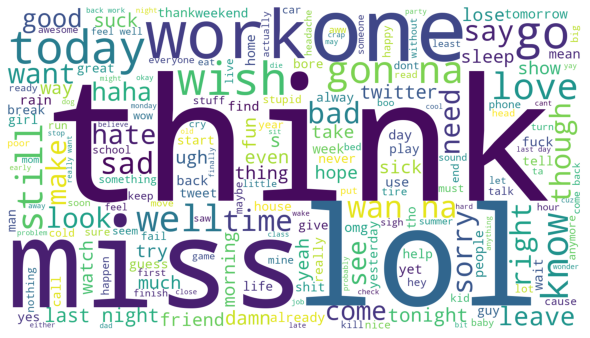

In [16]:
from wordcloud import WordCloud
word_cloud_df = df.loc[df['target'] == 0,:]  #"negative"
all_words = ' '.join([text for text in word_cloud_df['text']])
 

wordcloud = WordCloud(width = 1600, height = 900, 
                      background_color ='white', 
                      min_font_size = 10).generate(all_words)
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### Transforming Dataset using TF-IDF Vectorizer

In [17]:
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

from sklearn.feature_extraction.text import TfidfVectorizer
tdidf_v = TfidfVectorizer(ngram_range =(1,3),tokenizer = token.tokenize)
text_counts = tdidf_v.fit_transform(df['text'])

In [18]:
X = text_counts
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state =5)

### Function For Model Evaluation

In [19]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model Building

#### Model 1: Bernoulli Naive Bayes

              precision    recall  f1-score   support

           0       0.79      0.72      0.76    159789
           1       0.75      0.81      0.78    160211

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



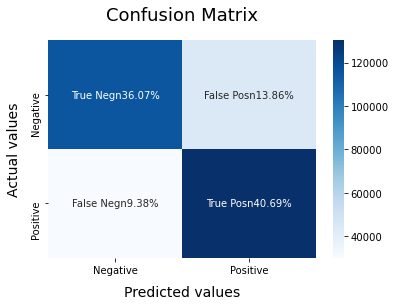

In [20]:
#Model 1
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

In [21]:
print("score on test: " + str(BNBmodel.score(X_test, y_test)))
print("score on train: "+ str(BNBmodel.score(X_train, y_train)))

score on test: 0.7676125
score on train: 0.94282265625


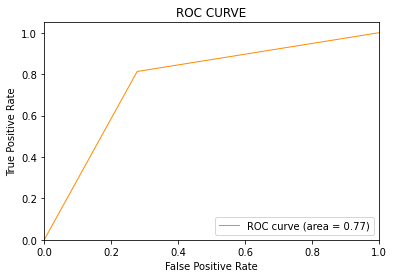

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model 2: Support Vector Machines

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159789
           1       0.77      0.81      0.79    160211

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



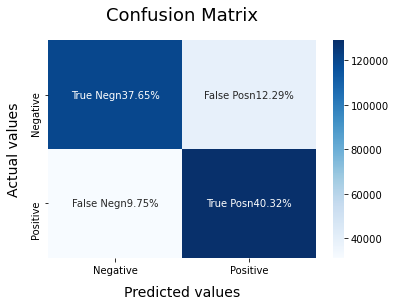

In [23]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

In [24]:
print("score on test: " + str(SVCmodel.score(X_test, y_test)))
print("score on train: "+ str(SVCmodel.score(X_train, y_train)))

score on test: 0.77968125
score on train: 0.98242265625


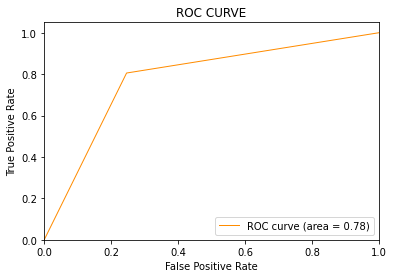

In [25]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### Model 3: Logistic Regression

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159789
           1       0.77      0.81      0.79    160211

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



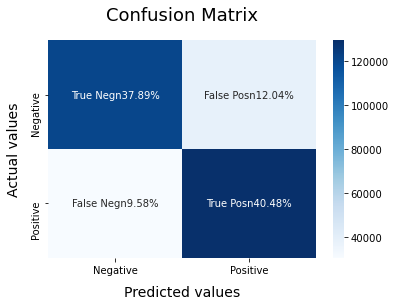

In [26]:
#Model 3
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

In [27]:
print("score on test: " + str(LRmodel.score(X_test, y_test)))
print("score on train: "+ str(LRmodel.score(X_train, y_train)))

score on test: 0.78373125
score on train: 0.8649546875


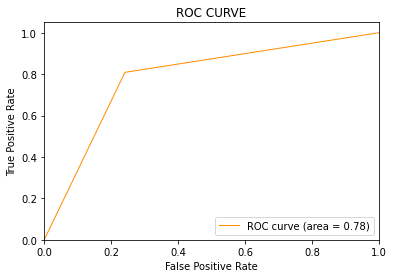

In [28]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Conclusion

- Logistic Regression and SVM perform almost equally with an AUROC score of 0.78.
- But the difference between training accuracy score and test accuracy score is comparitively less in Logistic Regression model.
- Therefore from the above three models Logistic Regression performs best.